# Import Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, model_selection
color = sns.color_palette()
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

# Changing current working directory

In [2]:
import os
cwd = os.getcwd()
print (cwd)
%cd "Instacart data"

C:\Users\Anisha Ganguly\Downloads\Instacart-Market-Basket-Analysis\Instacart-Market-Basket-Analysis
[WinError 2] The system cannot find the file specified: 'Instacart data'
C:\Users\Anisha Ganguly\Downloads\Instacart-Market-Basket-Analysis\Instacart-Market-Basket-Analysis


# Let's get the list of all the input files

In [3]:
#from subprocess import check_output
#print(check_output(["ls", "../Instacart data"]).decode("utf8"))

# Read Inputs into data frame

In [4]:
order_products_train = pd.read_csv("order_products__train.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")

Firstly, let's explore order_products_train and order_products_prior files. These files specify which products were purchased in each order. More specifically, order_products__prior contains previous order contents for all customers and order_products_train contains the last orders for some customers only.

In [5]:
print("The order_products_train size is : ", order_products_train.shape)
print("The order_products_prior size is : ", order_products_prior.shape)

The order_products_train size is :  (1384617, 4)
The order_products_prior size is :  (32434489, 4)


Now, let's concatenate them in the same order_products dataframe. This will concatenate all orders from previous customers plus new customers

In [6]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)

print("The order_products_all size is : ", order_products_all.shape)

The order_products_all size is :  (33819106, 4)


# Missing Data in all orders

In [7]:
total = order_products_all.isnull().sum().sort_values(ascending=False)
percent = (order_products_all.isnull().sum()/order_products_all.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total Missing', 'Percent'])
missing_data

,Total Missing,Percent
reordered,0,0.0
add_to_cart_order,0,0.0
product_id,0,0.0
order_id,0,0.0


There is no missing data in order_products_all dataset

# Reorder Frequency

In [8]:
grouped = order_products_all.groupby("reordered")["product_id"].aggregate({'Total_products': 'count'}).reset_index()
grouped['Ratios'] = grouped["Total_products"].apply(lambda x: x /grouped['Total_products'].sum())
grouped

C:\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,reordered,Total_products,Ratios
0,0,13863746,0.409938
1,1,19955360,0.590062


59 % of ordered products are previously ordered by customers.

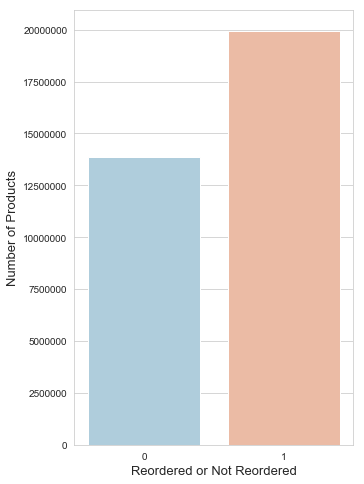

In [9]:
grouped  = grouped.groupby(['reordered']).sum()['Total_products'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(5, 8))
sns.barplot(grouped.index, grouped.values, palette='RdBu_r')
plt.ylabel('Number of Products', fontsize=13)
plt.xlabel('Reordered or Not Reordered', fontsize=13)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

# To predict which previously purchased products will be in a user’s next order

Step 1 We will start with reading the orders file.

In [10]:

orders_df = pd.read_csv("orders.csv", usecols=["order_id","user_id","order_number"])

Since the objective is to predict which previously purchased products will be in next order, let us first get the list of all products purchased by the customer.

Step 2 Create data frame with old purchase

In [11]:
# read the prior order file #
prior_df = pd.read_csv("order_products__prior.csv")

# merge with the orders file to get the user_id #
prior_df = pd.merge(prior_df, orders_df, how="inner", on="order_id")
prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,order_number
0,2,33120,1,1,202279,3
1,2,28985,2,1,202279,3
2,2,9327,3,0,202279,3
3,2,45918,4,1,202279,3
4,2,30035,5,0,202279,3


Step 3 Create data frame with latest purchase

In [12]:
# get the products and reorder status of the latest purchase of each user #
prior_grouped_df = prior_df.groupby("user_id")["order_number"].aggregate("max").reset_index()
prior_df_latest = pd.merge(prior_df, prior_grouped_df, how="inner", on=["user_id", "order_number"])
prior_df_latest = prior_df_latest[["user_id", "product_id", "reordered"]]
prior_df_latest.columns = ["user_id", "product_id", "reordered_latest"]
prior_df_latest.head()

,user_id,product_id,reordered_latest
0,59897,9755,1
1,59897,31487,0
2,59897,37510,1
3,59897,14576,1
4,59897,22105,0


Step 4. Get count of Number of reorders

In [13]:
# get the count of each product and number of reorders by the customer #
prior_df_agg = prior_df.groupby(["user_id","product_id"])["reordered"].aggregate(["count", "sum"]).reset_index()
prior_df_agg.columns = ["user_id", "product_id", "reordered_count", "reordered_sum"]
prior_df_agg.head()

,user_id,product_id,reordered_count,reordered_sum
0,1,196,10,9
1,1,10258,9,8
2,1,10326,1,0
3,1,12427,10,9
4,1,13032,3,2


Step 5 merge the prior df with latest df

In [14]:
prior_df_merge = pd.merge(prior_df_agg, prior_df_latest, how="left", on=["user_id","product_id"])
prior_df_merge.head()

,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,196,10,9,1.0
1,1,10258,9,8,1.0
2,1,10326,1,0,NaN
3,1,12427,10,9,1.0
4,1,13032,3,2,1.0


Read the train and test dataset and then merge with orders data to get the user_id for the corresponding order_id.

In [15]:
orders_df.drop(["order_number"],axis=1,inplace=True)

train_df = pd.read_csv("order_products__train.csv", usecols=["order_id"])
train_df.head()

,order_id
0,1
1,1
2,1
3,1
4,1


Step 6 Get distinct order id in train_df. This will help in joining the data frame with orders

In [16]:
train_df = train_df.groupby("order_id").aggregate("count").reset_index()
train_df.head()

,order_id
0,1
1,36
2,38
3,96
4,98


join with Orders data frame

In [17]:
train_df = pd.merge(train_df, orders_df, how="inner", on="order_id")
train_df.head()

,order_id,user_id
0,1,112108
1,36,79431
2,38,42756
3,96,17227
4,98,56463


In [18]:
test_df = pd.read_csv("sample_submission.csv", usecols=["order_id"])

test_df = pd.merge(test_df, orders_df, how="inner", on="order_id")
test_df.head()

,order_id,user_id
0,17,36855
1,34,35220
2,137,187107
3,182,115892
4,257,35581


Step 7 : Prepare test data frames

In [19]:
print(train_df.shape, test_df.shape)

(131209, 2) (75000, 2)


Step 8: Merge the train and test data with prior_df to get the products purchased previously by the customer.

In [20]:
train_df = pd.merge(train_df, prior_df_merge, how="inner", on="user_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,1,112108,2067,1,0,NaN
1,1,112108,5707,2,1,1.0
2,1,112108,11109,2,1,NaN
3,1,112108,14947,3,2,1.0
4,1,112108,22035,2,1,NaN


In [21]:
test_df = pd.merge(test_df, prior_df_merge, how="inner", on="user_id")
#del prior_df, prior_grouped_df, prior_df_latest
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest
0,17,36855,1283,1,0,NaN
1,17,36855,6291,1,0,NaN
2,17,36855,7035,1,0,NaN
3,17,36855,11494,1,0,NaN
4,17,36855,13107,3,2,1.0


In [22]:
products_df = pd.read_csv("products.csv", usecols=["product_id", "aisle_id", "department_id"])
products_df.head()

,product_id,aisle_id,department_id
0,1,61,19
1,2,104,13
2,3,94,7
3,4,38,1
4,5,5,13


Step 9 : Add more features to training data from Products data frame

In [23]:
train_df = pd.merge(train_df, products_df, how="inner", on="product_id")
train_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [24]:
test_df = pd.merge(test_df, products_df, how="inner", on="product_id")
test_df.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,17,36855,1283,1,0,NaN,100,21
1,657743,16994,1283,1,0,NaN,100,21
2,834223,92628,1283,1,0,NaN,100,21
3,1446886,75870,1283,1,0,NaN,100,21
4,1518981,118458,1283,3,2,NaN,100,21


Now we have all the products that has been purchased previously by the customer along with some characteristics / featrures. So we can use the train dataset to populate the target variable i.e., whether the product has been reordered in the next order.

In [25]:
train_y_df = pd.read_csv("order_products__train.csv", usecols=["order_id", "product_id", "reordered"])
train_y_df = pd.merge(train_y_df, orders_df, how="inner", on="order_id")
train_y_df = train_y_df[["user_id", "product_id", "reordered"]]
train_df = pd.merge(train_df, train_y_df, how="left", on=["user_id", "product_id"])
train_df["reordered"].fillna(0, inplace=True)
print(train_df.shape)

(8474661, 9)


In [26]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [27]:
X=train_df.drop('reordered',axis=1)

In [28]:
X.head()

,order_id,user_id,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,2067,1,0,NaN,3,19
1,96,17227,2067,1,0,NaN,3,19
2,3243,206024,2067,1,0,NaN,3,19
3,12950,11456,2067,1,0,0.0,3,19
4,17683,177724,2067,1,0,NaN,3,19


In [29]:
Y =train_df['reordered']

In [30]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

Step 10: split data into train and test sets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [32]:
model = XGBClassifier()

Step 11: Train the model using XGBClassifier

In [33]:
model.fit(X_train, y_train)

[01:27:44] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [34]:
y_pred = model.predict(X_test)

In [35]:
predictions = [round(value) for value in y_pred]

In [36]:
accuracy = accuracy_score(y_test, predictions)

### Accuracy for the  XGBoost Classifier

In [37]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.43%


In [38]:
# target variable for train set #
train_y = train_df.reordered.values

# dataframe for test set predictions #
out_df = test_df[["order_id", "product_id"]]

# drop the unnecessary columns #
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered"], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id"], axis=1))
print(train_df.shape, test_df.shape)

MemoryError: 

Step 12: Create XGb function

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

Step 13: Run the XGB function on training np array

In [ ]:
# run the xgboost model #
pred = runXGB(train_df, train_y, test_df)
#del train_df, test_df

# use a cut-off value to get the predictions #
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.ix[out_df["Pred"].astype('int')==1]

In [ ]:
# when there are more than 1 product, merge them to a single string #
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

Step 14: Load result in the output file

In [ ]:
# read the sample csv file and populate the products from predictions #
sub_df = pd.read_csv(data_path + "sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# when there are no predictions use "None" #
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [ ]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Logistic Regression model
clf=(LogisticRegression(C=0.02))

In [ ]:
#fitting the model
clf.fit(X_train, y_train)

In [ ]:
#predictions
pred=clf.predict(X_test)

In [ ]:
#accuracy score of Logistic Regression Model
print(accuracy_score(pred, y_test))

# Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [ ]:
clfrf.fit(X_train, y_train)

In [ ]:
#predictions
predrf=clfrf.predict(X_test)

In [ ]:
#accuracy score for the random forest model
accuracy_score(predrf, y_test)

# Light GBM

In [ ]:
import lightgbm as lgb

In [ ]:
train_X = lgb.Dataset(X_train)
train_y = lgb.Dataset(y_train)
test_X = lgb.Dataset(X_test)
test_y = lgb.Dataset(y_test)

In [ ]:
model= lgb.LGBMClassifier()

In [ ]:
model.fit(X_train, y_train)

In [ ]:
pred=model.predict(X_test)

In [ ]:
#accuracy score of Light GBM
print(accuracy_score(pred, y_test))

The text in the document is from source Instacart Kaggle Competition is licensed under CC BY 3.0 https://creativecommons.org/licenses/by/3.0/us/

The code in the document is by Onodera is licensed under the MIT License https://opensource.org/licenses/MIT